<h1>SM-NUMBA-SINTEL-convolved
</h1><br>


In [1]:
##################################################################################
# If run in google colab      #################################################### 
##################################################################################

from google.colab import drive
drive.mount("/content/gdrive")
%cd "./gdrive/My Drive/python_projects/FYP/"
!pip install tensorflow-gpu==2.1

ModuleNotFoundError: No module named 'google.colab'

In [2]:
# built in modules and libraries

import numpy as np
import importlib as imp
import cv2
import os
import matplotlib.pyplot as plt
import gc
import math
import time
import glob

# Custom libraries/classes

from components.classes.NumbaSimpleMatcher import Wrapper as Matcher

from components.classes.Metrix import Wrapper as Metrix
from components.classes.SintelReader import Wrapper as SintelReader
from components.classes.CSVReader import Wrapper as CSVReader
from components.classes.CSVWriter2 import Wrapper as CSVWriter



# singleton class: we will only have one progress bar
from components.classes.SimpleProgressBar import SimpleProgressBar


# Custom libraries/utils

from components.utils import plot_utils as plu
from components.utils import utils as u

##Configuring and testing data generator

File ./optimization/final//numba_sm/SM_VGG16_PREPROCESSED_GC.csv already exists, header has not been written.


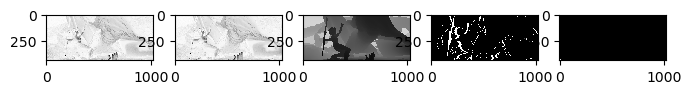

In [3]:
##################################################################################
# Setting default parameters  #################################################### 
##################################################################################

LOG_OUTPUT_ROOT = "./optimization/final/"

LOG_DIRECTORY = LOG_OUTPUT_ROOT+"/numba_sm/"

SPEC_MARKER = "SM_VGG16_PREPROCESSED_GC"

CSV_FILE_NAME =  SPEC_MARKER+".csv"

CSV_FILE_PATH = os.path.join(LOG_DIRECTORY, CSV_FILE_NAME)

##################################################################################
# Instantiating reader and csv writer ############################################
##################################################################################


STEREO_IMGS_ROOT = "./datasets/sintel/training"

IMG_READER = SintelReader(rootPath=STEREO_IMGS_ROOT)

CSV_WRITER = CSVWriter(file_path = CSV_FILE_PATH)

PROGRESS_VIEWER = SimpleProgressBar.get_instance()

NUM_SCENES = len(IMG_READER.get_available_scenes())

##################################################################################
# Testing reader configuration ###################################################
##################################################################################
## CSV writer should output if there has been a permission error or file already exists (which is not a problem)

IMG_READER.set_selected_scene('cave_4')

loaded_imgs = IMG_READER.get_selected_scene_next_files()

IMG_READER.plot_images_to_compare(loaded_imgs)


In [4]:
##################################################################################
# SPEC_DICT: columns that will be written to csv##################################
##################################################################################

SPEC_DICT = dict({})

SPEC_DICT["is_parallel"] = "True"

SPEC_DICT["alg_type"] =  SPEC_MARKER
SPEC_DICT["is_img_preprocessed"] = "yes"



SPEC_DICT["filter_strategy"] = "-"
SPEC_DICT["matching_mode"] =  "occlusions_added_to_the_groundtruth"
SPEC_DICT["matrix_init_mode"] = 2

# Have to be updated iteratively
SPEC_DICT["img_name_pretag"] = SPEC_MARKER
SPEC_DICT["img_name"] = SPEC_MARKER
SPEC_DICT["convolution_filters"] = SPEC_MARKER
SPEC_DICT["convolution_filters_pretag"] = SPEC_MARKER

In [5]:
##################################################################################
# Making sure that Tensorflow session is placed on the GPU, if available #########
##################################################################################

import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
try:
    tf.config.set_logical_device_configuration(
        physical_devices[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=5000),
          tf.config.LogicalDeviceConfiguration(memory_limit=5000)])

    logical_devices = tf.config.list_logical_devices('GPU')
    assert len(logical_devices) == len(physical_devices) + 1

    tf.config.set_logical_device_configuration(
        physical_devices[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=5000),
          tf.config.LogicalDeviceConfiguration(memory_limit=5000)])
except:
    # Invalid device or cannot modify logical devices once initialized.
    pass

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
##################################################################################
# Currently supported models: see tf_utils.py in components/utils ################
##################################################################################

from components.utils import tf_utils as tfu

##################################################################################
# Specifying IMG Dimensions for the model#########################################
##################################################################################

WIDTH = 1024
HEIGHT = 120
IMG_DIM_FOR_MODEL = [HEIGHT,WIDTH, 3]


##################################################################################
# Getting the "first-layer" model ################################################
##################################################################################

MODEL = tfu.get_vgg16_first_layer_model(IMG_DIM_FOR_MODEL)
MODEL.summary()

##################################################################################
# Uncomment the line below to check model configuration ##########################
##################################################################################

#model.get_config()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 1024, 3)]    0         
_________________________________________________________________
block1_conv1 (Conv2D)        multiple                  1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


In [7]:
##################################################################################
# PRE-PROCESSING IMAGES: first image in each scene ###############################
## CAVEAT :FAST-EXECUTION BUT LOADS OF STORAGE SPACE: RUN IT EVERY TIME ... ######
## ... if new execution environment: exclude them from GIT push    ###############
##################################################################################

PREPROCESS_IMGS_DIRECTORY = "./~optimization/pickled_slice_predictions/vgg16/"

#READER.convolve_slices_and_save(MODEL,  slice_height = HEIGHT, slice_width = WIDTH, output_directory=PREPROCESS_IMGS_DIRECTORY)


Found images: 23
Each image's shape: (2, 120, 1024, 64)


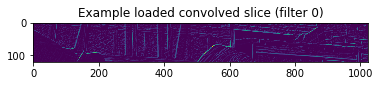

In [8]:
##################################################################################
# LOADING the preprocess images: one for each scene ##############################
##################################################################################

PREPROCESSED_PICKLES = IMG_READER.list_pickled_convolved(PREPROCESS_IMGS_DIRECTORY, WIDTH, HEIGHT)

PREPROCESSED_PICKLES = sorted(PREPROCESSED_PICKLES)

##################################################################################
# TESTING LOADED IMAGES VISUALLY #################################################
##################################################################################

one_pickle = IMG_READER.load_pickled_convolved(PREPROCESSED_PICKLES[0])
selected_filter_index = 0

print("Found images: {0}".format(len(PREPROCESSED_PICKLES)))
print("Each image's shape: {0}".format(one_pickle.shape))

fig = plt.figure()
ax = fig.gca()

ax.set_title("Example loaded convolved slice (filter {0})".format(selected_filter_index))
plt.imshow(one_pickle[0, :, :, selected_filter_index])


##Initialising loop parameters

In [9]:
##################################################################################
# Uncomment to see available scnenes #############################################
##################################################################################

#SCENES = reader.get_available_scenes()
#SCENES = sorted(SCENES)
#print(SCENES)

##################################################################################
# LOADING Grountruth images: only 23, can be loaded into memory###################
##################################################################################

STARTING_ROW_FOR_SLICES = 0
ALL_DISPARITIES = IMG_READER.get_all_sliced_disparities(HEIGHT, WIDTH, STARTING_ROW_FOR_SLICES = STARTING_ROW_FOR_SLICES)


In [10]:
##################################################################################
# GETTING N BEST PARAMETERS FROM THE SELECTED FILE ###############################
##################################################################################

SELECTED_CSV_FILE_PATH = "./optimization/final/numba_legacy/legacy_mixed_lines.csv"
CSV_READER = CSVReader(SELECTED_CSV_FILE_PATH)
CSV_FILE_DESCRIPTION = CSV_READER.get_description()

print(CSV_FILE_DESCRIPTION)

             match          gap         egap  matrix_init_mode      runtime  \
count  1760.000000  1760.000000  1760.000000            1760.0  1760.000000   
mean     75.000000   -45.000000   -40.000000               2.0    20.167556   
std      46.110824    28.730977    31.631764               0.0     0.244460   
min       0.000000   -90.000000   -90.000000               2.0    19.054626   
25%      37.500000   -70.000000   -70.000000               2.0    20.104191   
50%      75.000000   -45.000000   -40.000000               2.0    20.180402   
75%     112.500000   -20.000000   -10.000000               2.0    20.239465   
max     150.000000     0.000000    10.000000               2.0    22.554628   

       euclid_distance           mse      ABS_ERR  
count      1760.000000   1760.000000  1760.000000  
mean      40351.744597  13859.730032    94.086499  
std        1964.868976   1411.572178     5.112703  
min       37361.034515  11853.319463    85.450280  
25%       39448.640176  1321

In [11]:
top_n_config = []

n = 3


selected_metric = "ABS_ERR"


res = CSV_READER.get_best_n_params(n, selected_metric)
top_n_config.append(res)

selected_metric = "mse"

res = CSV_READER.get_best_n_params(n, selected_metric)
top_n_config.append(res)

selected_metric = "euclid_distance"

res = CSV_READER.get_best_n_params(n, selected_metric)
top_n_config.append(res)

top_n_config.append([60, -20, -1, 0])
LOADED_BEST_PARAMS = np.vstack(top_n_config)
print(LOADED_BEST_PARAMS.shape[0])
print("Please enter the estimated runtime per images in seconds below:")

runtime_multiplyer = 10
#runtime_multiplyer = input()

10
Please enter the estimated runtime per images in seconds below:


In [12]:
NUMBER_OF_ITERATIONS = len(LOADED_BEST_PARAMS)  * NUM_SCENES *64
est_runtime = int(NUMBER_OF_ITERATIONS) * float(runtime_multiplyer)

print("The number of iterations based on the params: {0}".format(round(NUMBER_OF_ITERATIONS)))
print("The amount of time (s) needed to perform the parameter search: {0}".format(est_runtime))
print("The amount of time (h) needed to perform the parameter search: {0}".format(est_runtime/3600))

The number of iterations based on the params: 14720
The amount of time (s) needed to perform the parameter search: 147200.0
The amount of time (h) needed to perform the parameter search: 40.888888888888886


In [13]:
from components.classes import SintelThreadProvider as STP

q = STP.Queue(5)
pickled_file_list = [] #todo here
dataLoaderThread = STP.SintelThreadProvider(name="data_provider_1", queue=q, fileList = PREPROCESSED_PICKLES)
dataLoaderThread.start()

while(not dataLoaderThread.isReady()):
    time.sleep(1)
print("Queue has been filled up.")
gts = [SintelReader.add_masks_to_raw_disparity(ALL_DISPARITIES[i, 0], ALL_DISPARITIES[i, 1], ALL_DISPARITIES[i, 2]) for i in (range(ALL_DISPARITIES.shape[0]))]



Queue has been filled up.


In [14]:
NEXT_IMAGE = q.pop()
OUTER_LOOP_COUNTER = 0
INTERNAL_LOOP_COUNTER = 0

import logging
logging.basicConfig(level=logging.WARNING,
                    format='(%(threadName)-9s) %(message)s', )

In [21]:
while(NEXT_IMAGE is not None):
    
    CURRENT_GROUNDTRUTH = gts[OUTER_LOOP_COUNTER]
    
    OUTER_LOOP_COUNTER+=1
    
    matcher = Matcher(0, 0, 0)
    matcher.configure_instance()   

    for best_params in LOADED_BEST_PARAMS:
        match = SPEC_DICT["match"] = best_params[0]
        gap = SPEC_DICT["gap"] = best_params[1]
        egap = SPEC_DICT["egap"] = best_params[2]

        matcher._match=match
        matcher._gap=gap
        matcher._egap=egap
    
        for filter_index in range(64):

            SPEC_DICT["convolution_filters"] = SPEC_DICT["convolution_filters_pretag"]+str(filter_index)

            leftee = NEXT_IMAGE[filter_index, 0]
            rightee = NEXT_IMAGE[filter_index, 1]
  
            matcher.set_images(rightee, leftee)
            tic=time.time()

            x,raw_disp_map = matcher.run_pipeline()

            toc = time.time()
            
            SPEC_DICT["runtime"] = toc-tic
            
            SPEC_DICT["filter_strategy"] = "VGG16_one_by_one"
            
            SPEC_DICT["mse"] = Metrix.mse(raw_disp_map, CURRENT_GROUNDTRUTH)
            
            SPEC_DICT["euclid_distance"] =Metrix.eucledian_distance(raw_disp_map, CURRENT_GROUNDTRUTH)
            
            SPEC_DICT["ABS_ERR"] = Metrix.avgerr(raw_disp_map, CURRENT_GROUNDTRUTH, print=False)

            PROGRESS_VIEWER.progress_bar(INTERNAL_LOOP_COUNTER+1, NUMBER_OF_ITERATIONS, header= "Parameter search progress: ", progress_bar_steps=100)
            
            INTERNAL_LOOP_COUNTER+=1
            
            CSV_WRITER.append_new_sm_results(SPEC_DICT)
    
    nextImage = q.pop()
end_time = time.time()

Parameter search progress:  [----------------------------------------------------------------------------------------------------] 0.09 % completed: 13 / 14720 steps

PermissionError: [Errno 13] Permission denied: './optimization/final//numba_sm/SM_VGG16_PREPROCESSED_GC.csv'

##Running the optimisation

In [ ]:
print("The optimisation process taken {0} seconds or {1} hours".format((end_time-start_time), (end_time-start_time)/3600))